In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2022-dl-w4-p1/train.csv
/kaggle/input/2022-dl-w4-p1/test.csv
/kaggle/input/2022-dl-w4-p1/sample_submit.csv


In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras import regularizers, optimizers

from matplotlib import pyplot

In [3]:
train=pd.read_csv('/kaggle/input/2022-dl-w4-p1/train.csv')
test=pd.read_csv('/kaggle/input/2022-dl-w4-p1/test.csv')
submit=pd.read_csv('/kaggle/input/2022-dl-w4-p1/sample_submit.csv')

In [4]:
train.head()

,ID,1,2,3,4,5,6,7,8,9,...,3064,3065,3066,3067,3068,3069,3070,3071,3072,label
0,0,59,62,63,43,46,45,50,48,43,...,216,184,140,151,118,84,123,92,72,6
1,1,154,177,187,126,137,136,105,104,95,...,143,133,139,143,134,142,143,133,144,9
2,2,255,255,255,253,253,253,253,253,253,...,78,85,83,79,85,83,80,86,84,9
3,3,28,25,10,37,34,19,38,35,20,...,54,47,28,63,56,37,72,65,46,4
4,4,170,180,198,168,178,196,177,185,203,...,75,79,82,71,75,78,73,77,80,1


In [5]:
test.head()

,id,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,3072
0,0,158,112,49,159,111,47,165,116,51,...,145,24,77,124,34,84,129,21,67,110
1,1,235,235,235,231,231,231,232,232,232,...,163,168,183,178,180,195,191,186,200,199
2,2,158,190,222,158,187,218,139,166,194,...,37,5,6,8,4,5,3,7,8,7
3,3,155,156,149,167,176,187,176,179,193,...,53,60,63,50,64,65,52,73,68,50
4,4,65,68,50,70,81,64,48,64,46,...,147,143,179,136,154,185,146,128,156,117


In [6]:
train.shape
# test.shape

(50000, 3074)

In [7]:
y_train=train.label
x_train=train.drop(['ID','label'],axis=1)
x_test=test.drop('id',axis=1)

In [8]:
x_test.head()

,1,2,3,4,5,6,7,8,9,10,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,3072
0,158,112,49,159,111,47,165,116,51,166,...,145,24,77,124,34,84,129,21,67,110
1,235,235,235,231,231,231,232,232,232,232,...,163,168,183,178,180,195,191,186,200,199
2,158,190,222,158,187,218,139,166,194,132,...,37,5,6,8,4,5,3,7,8,7
3,155,156,149,167,176,187,176,179,193,190,...,53,60,63,50,64,65,52,73,68,50
4,65,68,50,70,81,64,48,64,46,30,...,147,143,179,136,154,185,146,128,156,117


In [9]:
(x_train, x_valid) = x_train[10000:], x_train[:10000]
(y_train, y_valid) = y_train[10000:], y_train[:10000]

In [10]:
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape)

(40000, 3072) (40000,) (10000, 3072) (10000,) (10000, 3072)


In [11]:
x_train=np.array(x_train).reshape(40000,32,32,-1)
x_valid=np.array(x_valid).reshape(10000,32,32,-1)
x_test=np.array(x_test).reshape(10000,32,32,-1)

In [12]:
print(x_train.shape, x_valid.shape, x_test.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)


In [13]:
np.array(x_train).reshape(40000,32,32, 3).shape

(40000, 32, 32, 3)

In [14]:
# 데이터 정규화
mean = np.mean(x_train, axis=(0,1,2,3))
std = np.std(x_train, axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_valid = (x_valid-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

In [15]:
# 레이블에 원-핫 인코딩 적용하기
num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes)
y_valid = np_utils.to_categorical(y_valid, num_classes)

In [16]:
y_train.shape

(40000, 10)

In [17]:
# GPU를 활용한 모델 학습을 위해 넘파이 데이터를 텐서 데이터로 변환

import tensorflow as tf
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)

2022-10-17 04:05:09.271007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 04:05:09.370842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 04:05:09.371685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 04:05:09.374980: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [18]:
# 데이터 강화하기
datagen = ImageDataGenerator(
    rotation_range=5, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)
datagen.fit(x_train)

In [19]:
base_hidden_units = 32
weight_decay = 1e-4
model = Sequential()

#Conv1
model.add(Conv2D(base_hidden_units, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

#Conv2
model.add(Conv2D(base_hidden_units, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

#POOL+Dropout
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Conv3
model.add(Conv2D(base_hidden_units*2, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Conv4
model.add(Conv2D(base_hidden_units*2, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

#POOL+Dropout
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Conv5
model.add(Conv2D(base_hidden_units*4, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Conv6
model.add(Conv2D(base_hidden_units*4, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

#POOL+Dropout
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))


# FC7
model.add(Flatten())
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

In [20]:
y_train.shape


(40000, 10)

In [21]:
import tensorflow

batch_size = 128
epochs = 30

tf.device("/device:GPU:0")
checkpointer = ModelCheckpoint(filepath='model.100epochs.hdf5', verbose=1, save_best_only=True)
optimizer = tensorflow.keras.optimizers.Adam(lr=0.0001, decay=1e-6) # 교재랑 다른부분!! 
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), callbacks=[checkpointer], steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs, verbose=2,validation_data=(x_valid, y_valid))

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-10-17 04:05:14.444460: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-10-17 04:05:16.843099: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


312/312 - 26s - loss: 2.8973 - accuracy: 0.2693 - val_loss: 2.1588 - val_accuracy: 0.2621

Epoch 00001: val_loss improved from inf to 2.15876, saving model to model.100epochs.hdf5
Epoch 2/30
312/312 - 17s - loss: 2.1848 - accuracy: 0.3557 - val_loss: 1.5230 - val_accuracy: 0.4825

Epoch 00002: val_loss improved from 2.15876 to 1.52304, saving model to model.100epochs.hdf5
Epoch 3/30
312/312 - 18s - loss: 1.9102 - accuracy: 0.3967 - val_loss: 1.4479 - val_accuracy: 0.5031

Epoch 00003: val_loss improved from 1.52304 to 1.44792, saving model to model.100epochs.hdf5
Epoch 4/30
312/312 - 17s - loss: 1.7640 - accuracy: 0.4322 - val_loss: 1.4033 - val_accuracy: 0.5205

Epoch 00004: val_loss improved from 1.44792 to 1.40330, saving model to model.100epochs.hdf5
Epoch 5/30
312/312 - 17s - loss: 1.6800 - accuracy: 0.4582 - val_loss: 1.3757 - val_accuracy: 0.5339

Epoch 00005: val_loss improved from 1.40330 to 1.37571, saving model to model.100epochs.hdf5
Epoch 6/30
312/312 - 17s - loss: 1.5850 

In [22]:
# scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
# print('\nTest result: %.3f loss:%.3f' % (scores[1]*100, scores[0]))

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54984 (\N{HANGUL SYLLABLE HUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47144 (\N{HANGUL SYLLABLE RYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython

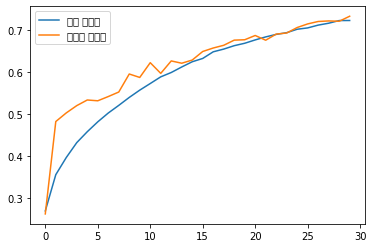

In [23]:
# 학습 곡선 그리기
pyplot.plot(history.history['accuracy'], label='훈련 데이터')
pyplot.plot(history.history['val_accuracy'], label='테스트 데이터')
pyplot.legend()
pyplot.show()

In [24]:
prediction = model.predict( x_test,
                            batch_size=None,
                            verbose="auto",
                            steps=None,
                            callbacks=None,
                            max_queue_size=10,
                            workers=1,
                            use_multiprocessing=False,
                        )

In [25]:
prediction.shape

(10000, 10)

In [26]:
submit['label']=np.argmax(prediction,axis=1)

In [27]:
## CSV파일로 저장
submit.to_csv("submission.csv",header=True,index=False)